# Opportunity Youth in South King County updated for 2019

## Import Necessary Packages

In [204]:
from sqlalchemy import create_engine
import pandas as pd


## Load Data from postgresQL database into Pandas DataFrame

In [205]:
engine = create_engine("postgresql:///opportunity_youth")

The following query selects all columns from the `pums_2017` database filtered by rows that meet the qualifications for South King County opportunity youth (i.e., ages 16-24 and neither currently enrolled nor employed).

In [206]:
query = """SELECT * 
           FROM pums_2017 
           WHERE (rt = 'P') 
           AND (puma = '11604' OR puma = '11605' OR puma = '11610' OR puma = '11613' OR puma = '11614' OR puma = '11615' OR puma = '11611' OR puma = '11612') 
           AND (agep BETWEEN 16 AND 24) 
           AND (sch = '1') 
           AND (esr = '3' OR esr = '6')"""

In [207]:
opp_youth = pd.read_sql(sql = query, con = engine) #read table query into Pandas DataFrame

In [208]:
opp_youth.head()

,rt,serialno,division,sporder,puma,region,st,adjinc,pwgtp,agep,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,2013000008875,9,05,11604,4,53,1061971,36.0,19.0,...,41.0,47.0,8.0,44.0,56.0,25.0,11.0,12.0,34.0,66.0
1,P,2013000030421,9,02,11611,4,53,1061971,11.0,19.0,...,16.0,12.0,10.0,9.0,9.0,10.0,13.0,11.0,10.0,10.0
2,P,2013000048962,9,05,11612,4,53,1061971,25.0,22.0,...,7.0,37.0,24.0,44.0,26.0,7.0,25.0,9.0,39.0,7.0
3,P,2013000047506,9,04,11615,4,53,1061971,5.0,20.0,...,1.0,6.0,6.0,7.0,5.0,2.0,4.0,1.0,6.0,1.0
4,P,2013000057563,9,05,11611,4,53,1061971,20.0,21.0,...,6.0,7.0,24.0,23.0,6.0,33.0,19.0,33.0,33.0,18.0


## Estimating Opportunity Youth

The estimate of 2019 opportunity youth is calculated by summing all the records, but each record is multiplied by the column `pwgtp` which is the weight that record holds for the total population. Here, if we sum `pwgtp` across all the rows, we get an estimate of the opportunity youth in South King County.

In [209]:
opp_youth_est = opp_youth['pwgtp'].sum()
print(opp_youth_est)

12438.0


If we want to get the number of opportunity youth represented by each PUMA in South King County in the newest dataset, we can use the following:

In [210]:
OYbyPUMA = opp_youth.groupby('puma')['pwgtp'].sum()

In [211]:
OYbyPUMA

puma
11604     916.0
11605     908.0
11610    1853.0
11611    2038.0
11612    1977.0
11613    2006.0
11614    1530.0
11615    1210.0
Name: pwgtp, dtype: float64

## Calculating Opportunity Youth Status by Age

The 2016 report on opportunity youth contains a breakdown of opportunity youth and total youth by age, their education status, and their employment status. Here, we recalculate these statistics using the updated information.

The following SQL query retuns a table with an estimate and percentage of the youth population that is an opportunity youth, not an opportunity youth, and youths working without a diploma.

In [212]:
query_total_population = """SELECT age_flag, oy_flag, SUM(pwgtp) as estimate, SUM(SUM(pwgtp)) OVER(PARTITION BY age_flag) AS total, ROUND((SUM(pwgtp) / SUM(SUM(pwgtp)) OVER(PARTITION BY age_flag)) * 100, 2) AS percent
                         FROM (
                               SELECT CASE WHEN (sch = '1' AND (esr = '3' OR esr = '6')) THEN 'OY' 
                                           WHEN (sch = '1' AND (schl::INTEGER < 16) AND (esr = '1' OR esr = '2')) THEN 'Working without diploma'
                                           ELSE 'Not OY' 
                                           END AS oy_flag,
                                      CASE WHEN (agep BETWEEN 16 AND 18) THEN 'Age 16-18'
                                           WHEN (agep BETWEEN 19 AND 21) THEN 'Age 19-21'
                                           ELSE 'Age 22-24'
                                           END AS age_flag,
                                      pwgtp
                               FROM pums_2017
                               WHERE (rt = 'P')
                               AND (puma = '11604' OR puma = '11605' OR puma = '11610' OR puma = '11613' OR puma = '11614' OR puma = '11615' OR puma = '11611' OR puma = '11612') 
                               AND (agep BETWEEN 16 AND 24)
                               ) AS temp
                          GROUP BY age_flag, oy_flag"""

In [213]:
total_population = pd.read_sql(sql = query_total_population, con = engine)

In [214]:
total_population

,age_flag,oy_flag,estimate,total,percent
0,Age 16-18,Not OY,35380.0,37933.0,93.27
1,Age 16-18,OY,2092.0,37933.0,5.51
2,Age 16-18,Working without diploma,461.0,37933.0,1.22
3,Age 19-21,Not OY,26579.0,32977.0,80.60
4,Age 19-21,OY,4749.0,32977.0,14.40
5,Age 19-21,Working without diploma,1649.0,32977.0,5.00
6,Age 22-24,Not OY,33253.0,40729.0,81.64
7,Age 22-24,OY,5597.0,40729.0,13.74
8,Age 22-24,Working without diploma,1879.0,40729.0,4.61


In [215]:
total_population['year'] = 2017

We saved the above table as a new table in postgreSQL, which we then used to create the totals columns below:

In [216]:
query_poptotals = """SELECT oy_flag, SUM(estimate) AS Group_Total, SUM(SUM(estimate)) OVER () AS Total_Population, ROUND(SUM(estimate) / SUM(SUM(estimate)) OVER() * 100, 2) AS percent 
                     FROM oy_age_counts
                     GROUP BY oy_flag"""

In [217]:
poptotals = pd.read_sql(sql = query_poptotals, con = engine)

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "oy_age_counts" does not exist
LINE 2:                      FROM oy_age_counts
                                  ^

[SQL: SELECT oy_flag, SUM(estimate) AS Group_Total, SUM(SUM(estimate)) OVER () AS Total_Population, ROUND(SUM(estimate) / SUM(SUM(estimate)) OVER() * 100, 2) AS percent 
                     FROM oy_age_counts
                     GROUP BY oy_flag]
(Background on this error at: http://sqlalche.me/e/f405)

In [218]:
poptotals

NameError: name 'poptotals' is not defined

In [219]:
poptotals['year'] = 2017

NameError: name 'poptotals' is not defined

The following query will return a similar table, but dividing up the opportunity youth by their level of education (no diploma, HS diploma or GED, some college but no degree, college degree (associates or higher).

In [220]:
query_opportunity_youth = """SELECT age_flag, edu_flag, SUM(pwgtp) as estimate, SUM(SUM(pwgtp)) OVER(PARTITION BY age_flag) AS total, ROUND((SUM(pwgtp) / SUM(SUM(pwgtp)) OVER(PARTITION BY age_flag)) * 100, 2) AS percent
                         FROM (
                               SELECT CASE WHEN (schl::INTEGER <= 15 OR schl = 'bb') THEN 'No Diploma' 
                                           WHEN (schl = '16' OR schl = '17') THEN 'HS Diploma or GED'
                                           WHEN (schl = '18' OR schl = '19')THEN 'College but no degree'
                                           ELSE 'College Degree Holder' 
                                           END AS edu_flag,
                                      CASE WHEN (agep BETWEEN 16 AND 18) THEN 'Age 16-18'
                                           WHEN (agep BETWEEN 19 AND 21) THEN 'Age 19-21'
                                           ELSE 'Age 22-24'
                                           END AS age_flag,
                                      pwgtp
                               FROM pums_2017
                               WHERE (rt = 'P')
                               AND (puma = '11604' OR puma = '11605' OR puma = '11610' OR puma = '11613' OR puma = '11614' OR puma = '11615' OR puma = '11611' OR puma = '11612') 
                               AND (agep BETWEEN 16 AND 24)
                               AND (sch = '1')
                               AND (esr = '3' OR esr = '6')
                               ) AS temp
                          GROUP BY age_flag, edu_flag"""

In [221]:
opportunity_youth = pd.read_sql(sql = query_opportunity_youth, con = engine)

In [222]:
opportunity_youth

,age_flag,edu_flag,estimate,total,percent
0,Age 16-18,College but no degree,143.0,2092.0,6.84
1,Age 16-18,HS Diploma or GED,833.0,2092.0,39.82
2,Age 16-18,No Diploma,1116.0,2092.0,53.35
3,Age 19-21,College Degree Holder,132.0,4749.0,2.78
4,Age 19-21,College but no degree,624.0,4749.0,13.14
5,Age 19-21,HS Diploma or GED,2651.0,4749.0,55.82
6,Age 19-21,No Diploma,1342.0,4749.0,28.26
7,Age 22-24,College Degree Holder,633.0,5597.0,11.31
8,Age 22-24,College but no degree,1228.0,5597.0,21.94
9,Age 22-24,HS Diploma or GED,2259.0,5597.0,40.36


In [223]:
opportunity_youth['year'] = 2017

We saved the above table as a new table in postgreSQL, which we then used to create the totals columns below:

In [224]:
query_OYtotals = """SELECT edu_flag, SUM(estimate) AS Group_Total, SUM(SUM(estimate)) OVER () AS Total_Population, ROUND(SUM(estimate) / SUM(SUM(estimate)) OVER() * 100, 2) AS percent 
                    FROM oy_age_counts_by_education
                    GROUP BY edu_flag"""

In [225]:
OYtotals = pd.read_sql(sql = query_OYtotals, con = engine)

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "oy_age_counts_by_education" does not exist
LINE 2:                     FROM oy_age_counts_by_education
                                 ^

[SQL: SELECT edu_flag, SUM(estimate) AS Group_Total, SUM(SUM(estimate)) OVER () AS Total_Population, ROUND(SUM(estimate) / SUM(SUM(estimate)) OVER() * 100, 2) AS percent 
                    FROM oy_age_counts_by_education
                    GROUP BY edu_flag]
(Background on this error at: http://sqlalche.me/e/f405)

In [226]:
OYtotals

NameError: name 'OYtotals' is not defined

In [227]:
OYtotals['year'] = 2017

NameError: name 'OYtotals' is not defined

Let's bring in the 2016 data for comparison (taken from page 2 on https://roadmapproject.org/wp-content/uploads/2018/09/Opportunity-Youth-2016-Data-Brief-v2.pdf).

In [228]:
educationtable2016 = pd.read_csv("2016educationtable - Sheet1.csv")
educationtabletotals2016 = pd.read_csv("2016educationtable_totals - Sheet1.csv")
opyouthtable2016 = pd.read_csv("2016opportunityyouthtable - Sheet1.csv")
opyouthtabletotals2016 = pd.read_csv("2016opportunityyouthtable_totals - Sheet1.csv")

FileNotFoundError: [Errno 2] File b'2016educationtable - Sheet1.csv' does not exist: b'2016educationtable - Sheet1.csv'

In [229]:
opyouthtable2016['year'] = 2016

NameError: name 'opyouthtable2016' is not defined

In [230]:
opyouthtabletotals2016['year'] = 2016

NameError: name 'opyouthtabletotals2016' is not defined

In [231]:
educationtable2016['year'] = 2016

NameError: name 'educationtable2016' is not defined

In [232]:
educationtabletotals2016['year'] = 2016

NameError: name 'educationtabletotals2016' is not defined

In [233]:
educationtable2016

NameError: name 'educationtable2016' is not defined

## Map South King County

Import necessary packages, load the puma shape files, set the shape files to a web mercator projection.


In [234]:
import geopandas
from matplotlib import pyplot as plt
import folium
from mpl_toolkits.axes_grid1 import make_axes_locatable

wa_puma = geopandas.read_file("data/raw/tl_2017_53_puma10.shp")
wa_puma = wa_puma.to_crs(epsg='3857') # convert shape file data to web mercator (ESPG 3857)

Import functions 

In [235]:
from map_function import *

Create a new column in data drame to identify the puma shape files as being in South King County

In [236]:
wa_puma["king_county"]=wa_puma["PUMACE10"].map(lambda x: is_county(x))

Create a DF with just the South King counties, then map them on a live Folium map 


In [237]:
s_king_df = wa_puma.loc[wa_puma['king_county']==2]

sm = folium.Map([47.5, -122.3502], zoom_start=9.4, crs='EPSG3857', zoom_control = False,tiles="Stamen Toner", opacity = 20 )

folium.GeoJson(s_king_df).add_to(sm)
sm.save('S_King_County_Locator_Map.html')
sm



## Visualize the spatial distribution of the Opportunity Youth across South King County


Join the total estimated number of OY into the shapefile dataframe 

In [238]:
s_king_df.index = s_king_df['PUMACE10'] #reset the s_king_df index to be the puma id
OYbyPUMA_df = pd.DataFrame(OYbyPUMA)#create the dataframe containing the estimated # of OY
s_king_df = s_king_df.join(OYbyPUMA_df, how='left') #join them together



Build the choropleth map displaying total population


''

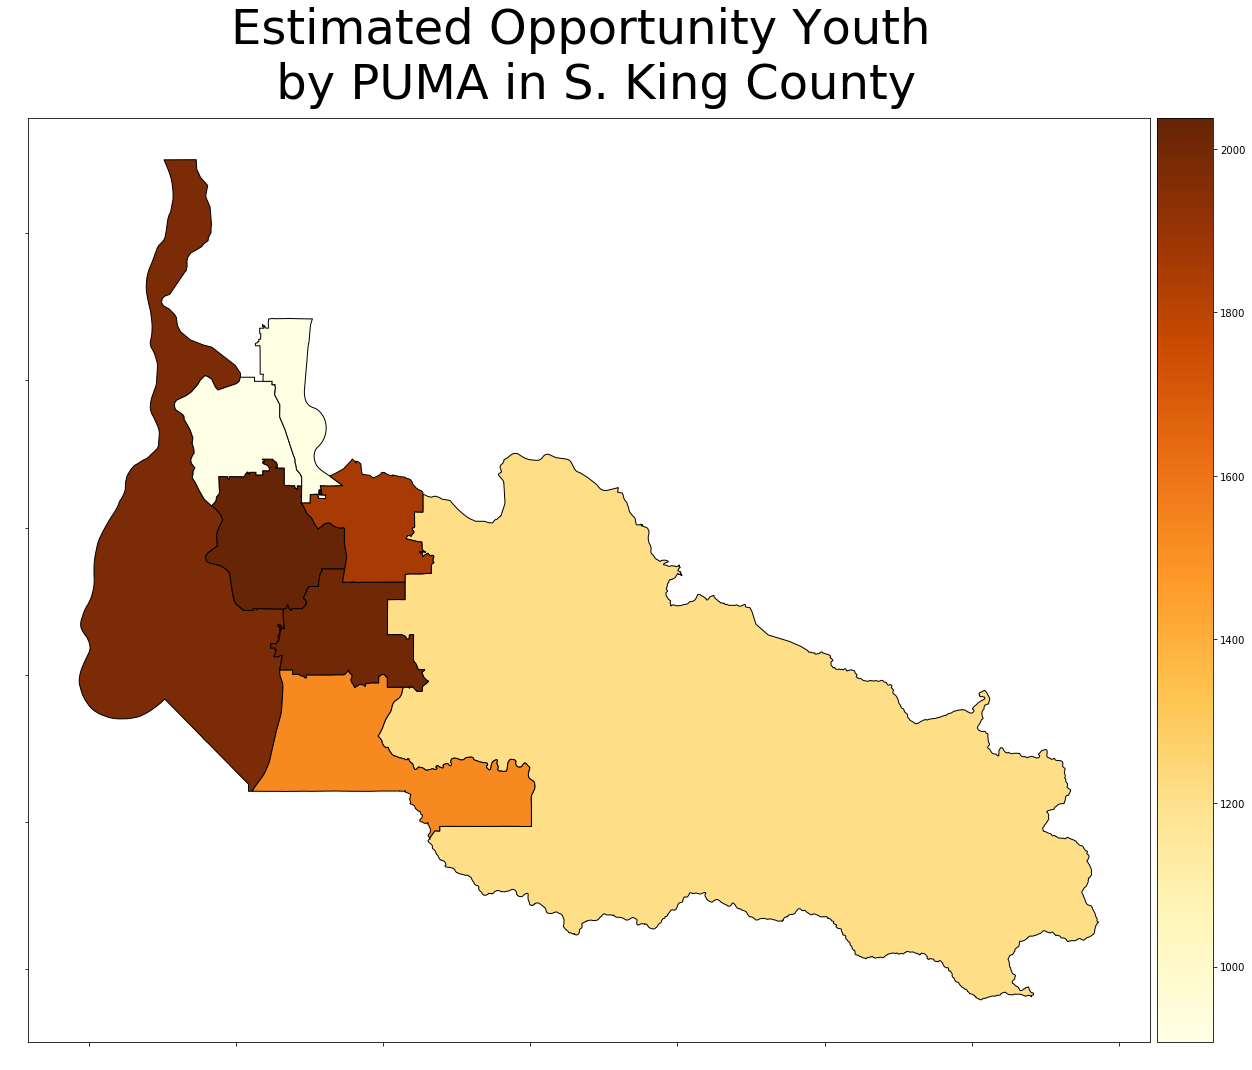

In [259]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(22,17)

ax.set_yticklabels([])
ax.set_ylabel(' ')

ax.set_xticklabels([])
ax.set_xlabel(' ')

ax.set_title("""Estimated Opportunity Youth \n by PUMA in S. King County""", 
             fontdict = {'fontsize':'48'},
              pad=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

s_king_df.plot(column = "pwgtp", ax=ax, cmap = "YlOrBr", legend = True, cax = cax,
              edgecolor ='black')

plt.savefig("OY_by_puma_map.png", dpi =200)
;


Visualize the spatial distribition of OY by percent of total youth population


In [260]:
#perform a new sql query pulling in total youth population by puma region
total_oy_query = """SELECT * 
           FROM pums_2017 
           WHERE (rt = 'P') 
           AND (puma = '11604' OR puma = '11605' OR puma = '11610' OR puma = '11613' OR puma = '11614' OR puma = '11615' OR puma = '11611' OR puma = '11612') 
           AND (agep BETWEEN 16 AND 24) 
"""

#read table query into Pandas DataFrame, make a new Panda DF with the total youth population by PUMA 
total_youth = pd.read_sql(sql = total_oy_query, con = engine) 
total_byPUMA = total_youth.groupby('puma')['pwgtp'].sum()
total_byPUMA_df = pd.DataFrame(total_byPUMA)
total_byPUMA_df = total_byPUMA_df.rename(columns={'pwgtp':'total_youth_pop'})


In [261]:
#Join the Total Population DF to the South King County Puma DF
s_king_df = s_king_df.join(total_byPUMA_df, how='left') 


ValueError: columns overlap but no suffix specified: Index(['total_youth_pop'], dtype='object')

In [262]:
#Add a column for the percent of OY to the geo dataframe to be mapped
s_king_df['OY_percent']=round(s_king_df['pwgtp']/s_king_df['total_youth_pop']*100)


''

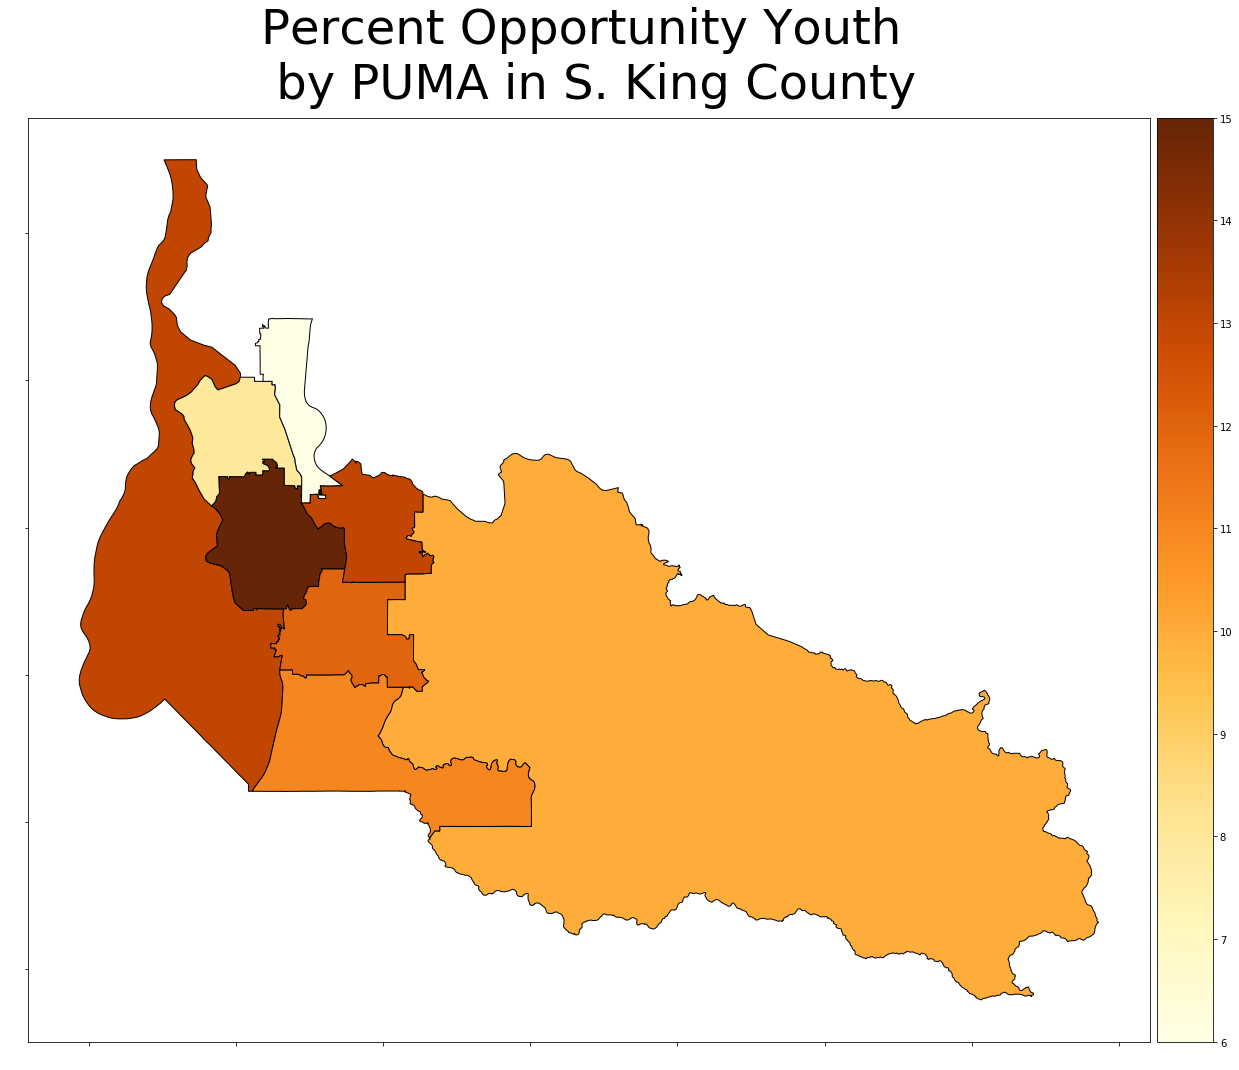

In [263]:
#Construct the choropleth map
fig_2, ax_2 = plt.subplots(1,1)
fig_2.set_size_inches(22,17)


ax_2.set_yticklabels([])
ax_2.set_ylabel(" " )

ax_2.set_xticklabels([])
ax_2.set_xlabel(' ')

ax_2.set_title("""Percent Opportunity Youth \n by PUMA in S. King County""" , 
               fontdict = {'fontsize':'48'},
              pad=20)

divider_2 = make_axes_locatable(ax_2)
cax_2 = divider_2.append_axes("right", size="5%", pad=0.1)

s_king_df.plot(column = "OY_percent", ax=ax_2, legend = True, cmap = "YlOrBr", cax=cax_2,
              edgecolor ='black')

plt.savefig("OY_percent_puma_map.png", dpi=200)
;